Upon data preparation and the formulation of batch functions, we proceed to deploy Deep Learning for 3D segmentation through the adoption of a straightforward 3D U-net architecture. It is imperative to note that images are anticipated to manifest as 128x128x128x3 numpy arrays, where the '3' signifies the three channels attributed to test_image_flair, test_image_t1ce, and test_image_t2. Conversely, masks are envisaged as 128x128x128x3 numpy arrays, where '4' designates the four labels.

In [131]:
import os
import numpy as np
from Batch_functions import imageLoader
import tensorflow as tf
import keras
from matplotlib import pyplot as plt
import glob
import random
import segmentation_models as sm

AssertionError: Duplicate registrations for type 'experimentalOptimizer'

Initially, we specify the directory containing the image and mask files. Subsequently, we visualize the data.

In [52]:
train_img_dir = 'd:/BraTS2020/train_dataset/train/images/'
train_mask_dir = 'd:/BraTS2020/train_dataset/train/masks/'

val_img_dir = 'd:/BraTS2020/train_dataset/val/images/'
val_mask_dir = 'd:/BraTS2020/train_dataset/val/masks/'

train_img_list=os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

val_img_list=os.listdir(val_img_dir)
val_mask_list = os.listdir(val_mask_dir)

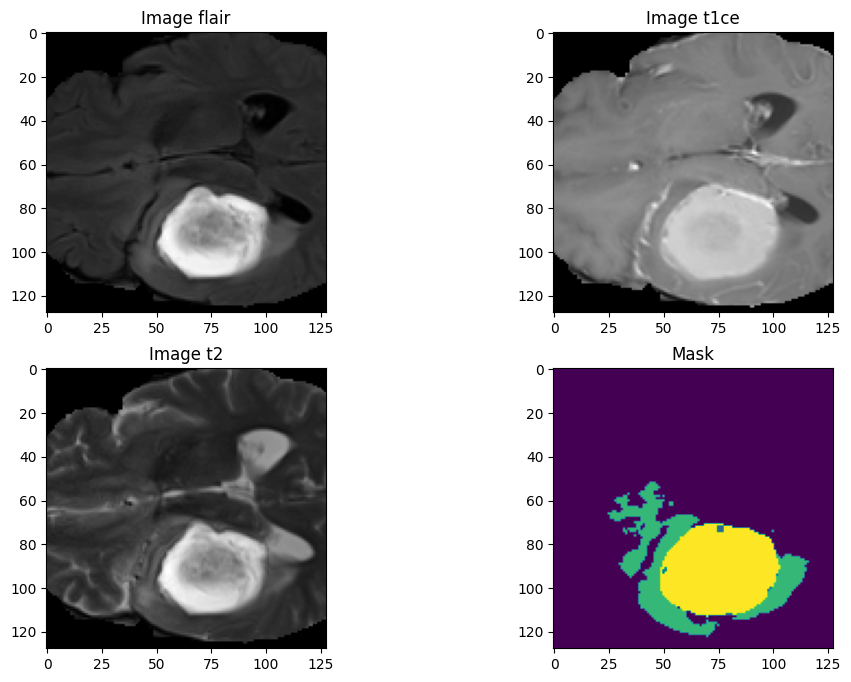

In [81]:
num_images = len(os.listdir(train_img_dir))

img_num = random.randint(0,num_images-1)
test_img = np.load(train_img_dir+train_img_list[img_num])
test_mask = np.load(train_mask_dir+train_mask_list[img_num])
test_mask = np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

Now that we check the correct visualization of the data, let's define train and validation. 

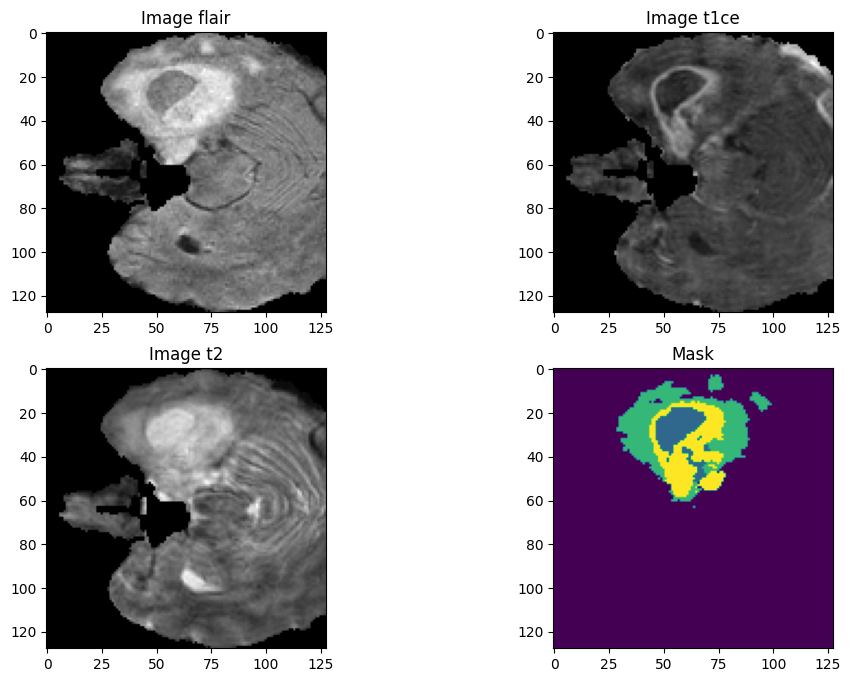

In [98]:
batch_size = 2 #if we had additional memory processing capacity, we could consider augmenting the batch size

train_img_datagen = imageLoader(train_img_dir, train_img_list, train_mask_dir, train_mask_list, batch_size)

val_img_datagen = imageLoader(val_img_dir, val_img_list, val_mask_dir, val_mask_list, batch_size)

#Verify generator.... In python 3 next() is renamed as __next__()
img, msk = train_img_datagen.__next__()

img_num = random.randint(0,img.shape[0]-1)
test_img=img[img_num]
test_mask=msk[img_num]
test_mask=np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [ ]:
#Define loss, metrics and optimizer to be used for training
wt0, wt1, wt2, wt3 = 0.25,0.25,0.25,0.25
dice_loss = sm.losses.DiceLoss(class_weights=np.array([wt0, wt1, wt2, wt3])) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5)]

LR = 0.0001
optim = keras.optimizers.Adam(LR)